Generate Adversarial Examples with PGD attack. Using ImageNet pretrained ResNet50 model with Pytorch implementation 

The Google Colab notebook can be found in the link below: 

https://drive.google.com/file/d/1JuqQLWNkONFx14P8vrzY_Pq1scvu4XJo/view?usp=sharing

In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 
import glob 

from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from torch.autograd import Variable
from torchvision import transforms

In [2]:
# Define PGD attack 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

def clamp(X, lower_limit, upper_limit):
    return torch.max(torch.min(X, upper_limit), lower_limit)

def pgd_attack(model, X, y, device, attack_params, logadv=False): 
    """
        Reference: 
            https://github.com/yaodongyu/TRADES/blob/master/pgd_attack_cifar10.py 
            L2 attack: https://github.com/locuslab/robust_overfitting/blob/master/train_cifar.py
        Args: 
            model: pretrained model 
            X: input tensor
            y: input target 
            attack_params:
                loss_type: 'ce', 'kl'
                epsilon: attack boundary
                step_size: attack step size 
                num_steps: number attack step 
                order: norm order (norm l2 or linf)
                random_init: random starting point 
                x_min, x_max: range of data 
    """
    # model.eval()

    X_adv = Variable(X.data, requires_grad=True)

    not_targeted = 1 if not attack_params['targeted'] else -1 
    target = y if not attack_params['targeted'] else attack_params['y_target'] 

    if attack_params['random_init']:
        random_noise = torch.FloatTensor(*X_adv.shape).uniform_(-attack_params['epsilon'], 
                                                            attack_params['epsilon']).to(device)
        X_adv = Variable(X_adv.data + random_noise, requires_grad=True)
    
    X_adves = []
    for _ in range(attack_params['num_steps']):
        opt = optim.SGD([X_adv], lr=1e-3)
        opt.zero_grad()

        with torch.enable_grad():
            if attack_params['loss_type'] == 'ce':
                loss = nn.CrossEntropyLoss()(model(X_adv), target)
            elif attack_params['loss_type'] == 'kl': 
                loss = nn.KLDivLoss()(F.softmax(model(X_adv), dim=1), 
                                    F.softmax(model(X), dim=1))

        loss.backward()
        eta = attack_params['step_size'] * X_adv.grad.data.sign()
        X_adv = Variable(X_adv.data + not_targeted * eta, requires_grad=True)
        eta = torch.clamp(X_adv.data - X.data, 
                            -attack_params['epsilon'], 
                            attack_params['epsilon'])
        X_adv = Variable(X.data + eta, requires_grad=True)
        X_adv = Variable(torch.clamp(X_adv, 
                            attack_params['x_min'], 
                            attack_params['x_max']), requires_grad=True)

        if logadv:
            X_adves.append(X_adv)

    # switch_status(model, status)
    X_adv = Variable(X_adv.data, requires_grad=False)
    return X_adv, X_adves

In [3]:
import os 
import urllib.request

# Download images 
os.makedirs('images', exist_ok=True)
os.makedirs('results', exist_ok=True)

urllib.request.urlretrieve('https://github.com/tuananhbui89/demo_attack/raw/main/images/koala.jpeg', 'images/koala.jpeg')
urllib.request.urlretrieve('https://github.com/tuananhbui89/demo_attack/raw/main/images/koala_2.png', 'images/koala_2.png')
urllib.request.urlretrieve('https://github.com/tuananhbui89/demo_attack/raw/main/images/kangaroo.jpeg', 'images/kangaroo.jpeg')
urllib.request.urlretrieve('https://github.com/tuananhbui89/demo_attack/raw/main/images/kangaroo_2.png', 'images/kangaroo_2.png')
urllib.request.urlretrieve('https://github.com/tuananhbui89/demo_attack/raw/main/images/kagaroo3.jpeg', 'images/kagaroo3.jpeg')


('images/kagaroo3.jpeg', <http.client.HTTPMessage at 0x7fb981585db0>)

Image: images/kangaroo.jpeg


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


wallaby: 11.7%
balloon: 100.0%


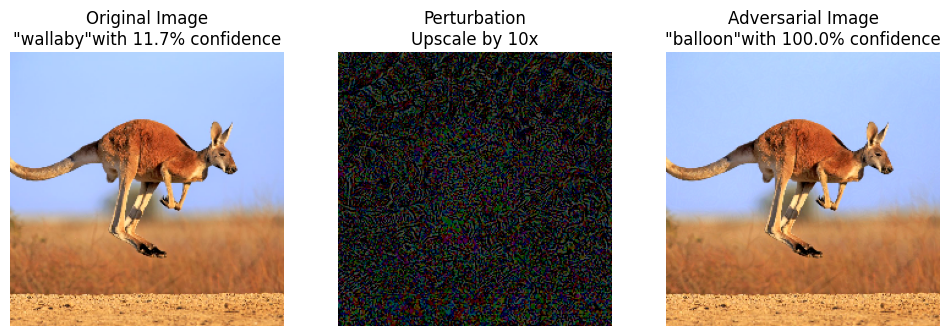

Image: images/koala.jpeg
koala: 49.8%
balloon: 100.0%


<Figure size 640x480 with 0 Axes>

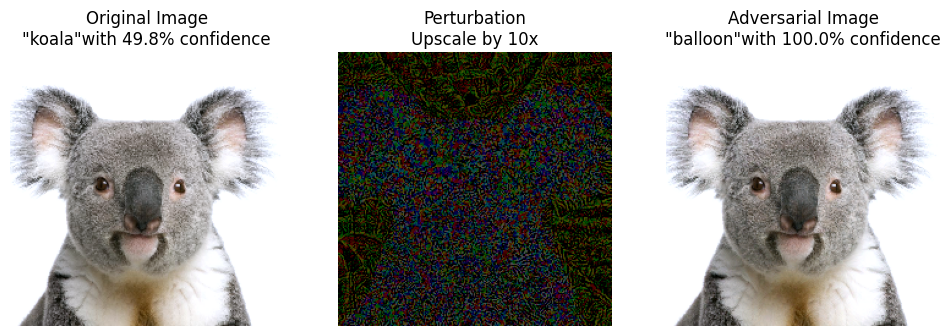

Image: images/kagaroo3.jpeg
wallaby: 34.2%
balloon: 100.0%


<Figure size 640x480 with 0 Axes>

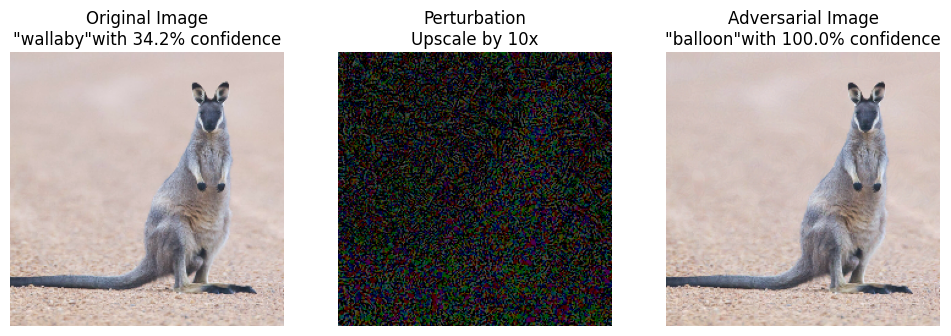

Image: images/kangaroo_2.png
wallaby: 36.0%
balloon: 100.0%


<Figure size 640x480 with 0 Axes>

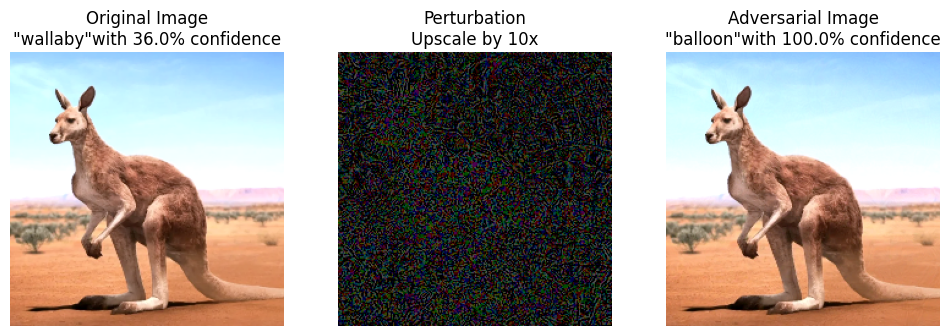

Image: images/koala_2.png
comic book: 12.3%
balloon: 100.0%


<Figure size 640x480 with 0 Axes>

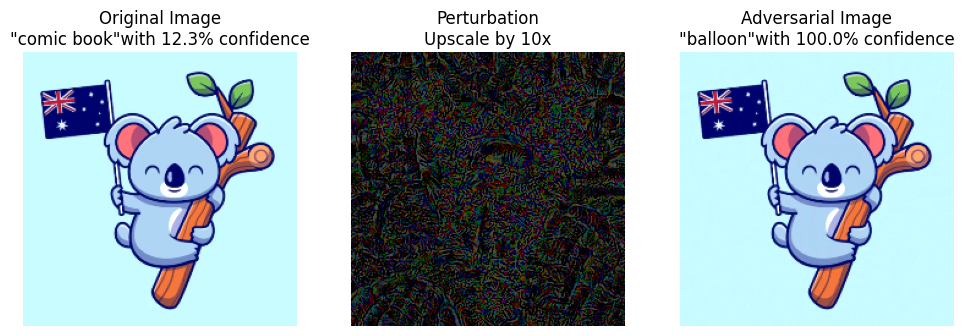

<Figure size 640x480 with 0 Axes>

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.to(device)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Note that the image need to preprocess before feed into the model and reverse to the original range to visualize 
mean = torch.tensor([0.4915, 0.4823, 0.4468])
std = torch.tensor([0.2470, 0.2435, 0.2616])

normalize = transforms.Normalize(mean.tolist(), std.tolist()) 
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

# List all available images in the folders
all_images = glob.glob('images/*.jpeg') + glob.glob('images/*.png')


for idx, path in enumerate(all_images): 
    print("Image: {}".format(path))
    img = read_image(path)
    img = img[:3, :, :] # Remove alpha channel in png image 

    # Step 3: Apply inference preprocessing transforms
    batch = preprocess(img).unsqueeze(0).to(device)

    # Step 4: Use the model and print the predicted category
    prediction = model(batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    print(f"{category_name}: {100 * score:.1f}%")

    # Define attack params 
    attack_params = {
        'projecting': True, 
        'random_init': True, 
        'epsilon': 0.031, # 8/255, perturbation size 
        'num_steps': 100, 
        'step_size': 0.007, # 2/255, step size
        'loss_type': 'ce',
        'x_min': batch.min().item(), 
        'x_max': batch.max().item(),
        'y_target': torch.tensor([417]).to(device), # targeted class: ballon, 
        'targeted': True,
    }

    batch = batch.to(device)
    target = torch.tensor([class_id]).to(device)
    X_adv, _ = pgd_attack(model, batch, target, device, attack_params)
    X_adv = Variable(X_adv.data, requires_grad=False)

    perturb = X_adv - batch

    # print("Input range")
    # print(f"Min: {batch.min().item()}")
    # print(f"Max: {batch.max().item()}")
    # print("")

    # print("Output range")
    # print(f"Min: {X_adv.min().item()}")
    # print(f"Max: {X_adv.max().item()}")
    # print("")

    # print("Perturb range")
    # print(f"Min: {perturb.min().item()}")
    # print(f"Max: {perturb.max().item()}")
    # print("")

    prediction = model(X_adv).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    adv_score = prediction[class_id].item()
    adv_category_name = weights.meta["categories"][class_id]
    print(f"{adv_category_name}: {100 * adv_score:.1f}%")

    # Plot the original image and the adversarial image with the perturbation and prediction 
    vmin = 0
    vmax = 255

    # convert to original image range 
    batch = unnormalize(batch)
    # perturb = unnormalize(perturb)
    X_adv = unnormalize(X_adv)

    # print("Input range - After unnormalize")
    # print(f"Min: {batch.min().item()}")
    # print(f"Max: {batch.max().item()}")
    # print("")

    # print("Output range - After unnormalize")
    # print(f"Min: {X_adv.min().item()}")
    # print(f"Max: {X_adv.max().item()}")
    # print("")

    # print("Perturb range - After unnormalize")
    # print(f"Min: {perturb.min().item()}")
    # print(f"Max: {perturb.max().item()}")
    # print("")

    # upscale the perturbation
    k = 10 
    perturb = perturb * k

    # clip to original image range 
    batch = torch.clamp(batch, 0, 1)
    perturb = torch.clamp(perturb, 0, 1)
    X_adv = torch.clamp(X_adv, 0, 1)

    batch = batch[0].permute(1, 2, 0).detach().cpu().numpy() * 255 
    perturb = perturb[0].permute(1, 2, 0).detach().cpu().numpy() * 255
    X_adv = X_adv[0].permute(1, 2, 0).detach().cpu().numpy() * 255



    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(batch.astype(np.uint8), vmin=vmin, vmax=vmax)
    ax[0].set_title('Original Image' + '\n' + '"' + category_name + '"' + 'with {:.1f}% confidence'.format(100 * score))
    ax[0].axis('off')


    ax[1].imshow(perturb.astype(np.uint8), vmin=vmin, vmax=vmax)
    ax[1].set_title('Perturbation' + '\n' + 'Upscale by {}x'.format(k))
    ax[1].axis('off')

    ax[2].imshow(X_adv.astype(np.uint8), vmin=vmin, vmax=vmax)
    ax[2].set_title('Adversarial Image' + '\n' + '"' + adv_category_name + '"' + 'with {:.1f}% confidence'.format(100 * adv_score) )
    ax[2].axis('off')

    plt.show()
    plt.savefig('results/adversarial_{}_{}.png'.format(idx, k), dpi=300)
